  SISTEMA DE AN√ÅLISIS BIOMEC√ÅNICO PARA SALTO LARGO

CARACTER√çSTICAS DEL SISTEMA:
‚úì An√°lisis visual en tiempo real con MediaPipe
‚úì Simulaci√≥n de 11 sensores IMU distribuidos
‚úì C√°lculo autom√°tico de m√©tricas biomec√°nicas
‚úì Visualizaci√≥n gr√°fica en tiempo real
‚úì Exportaci√≥n de datos para an√°lisis posterior

REQUISITOS T√âCNICOS:
- C√°mara web conectada
- Python 3.8+ con librer√≠as: opencv, mediapipe, tkinter
- Iluminaci√≥n adecuada para detecci√≥n de pose

Iniciando interfaz gr√°fica...
------------------------------------------------------------


2025-08-12 16:12:48,862 - INFO - C√°mara inicializada: 1280x720 @ 30.0 FPS
2025-08-12 16:12:50,460 - INFO - Grabaci√≥n visual iniciada
2025-08-12 16:12:50,462 - INFO - Simulaci√≥n IMU iniciada
2025-08-12 16:12:57,793 - INFO - Grabaci√≥n visual detenida
2025-08-12 16:12:57,804 - INFO - Simulaci√≥n IMU detenida
2025-08-12 16:13:09,125 - INFO - Grabaci√≥n visual iniciada
2025-08-12 16:13:09,134 - INFO - Simulaci√≥n IMU iniciada
2025-08-12 16:13:14,261 - INFO - Grabaci√≥n visual detenida
2025-08-12 16:13:14,274 - INFO - Simulaci√≥n IMU detenida



Sistema finalizado correctamente.


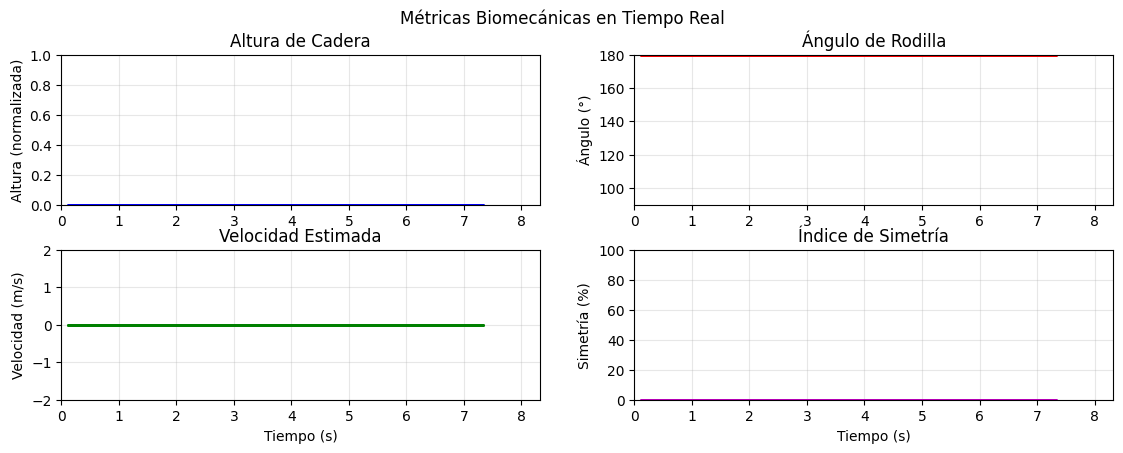

In [1]:
"""
SISTEMA DE AN√ÅLISIS BIOMEC√ÅNICO PARA SALTO LARGO
================================================================

Este sistema implementa una soluci√≥n h√≠brida inercial-visual para el an√°lisis 
t√©cnico y f√≠sico del salto largo en deportistas. Combina:

1. AN√ÅLISIS VISUAL: Utiliza MediaPipe para detectar 33 puntos clave del cuerpo humano
2. SIMULACI√ìN IMU: Simula 11 sensores inerciales distribuidos estrat√©gicamente
3. AN√ÅLISIS BIOMEC√ÅNICO: Calcula m√©tricas espec√≠ficas del salto largo en tiempo real
4. INTERFAZ GR√ÅFICA: Proporciona visualizaci√≥n y control del sistema

CARACTER√çSTICAS PRINCIPALES:
- An√°lisis en tiempo real de t√©cnica de salto
- C√°lculo de centro de masa corporal
- Medici√≥n de √°ngulos articulares cr√≠ticos
- Evaluaci√≥n de simetr√≠a bilateral
- Exportaci√≥n de datos para an√°lisis posterior

REQUISITOS T√âCNICOS:
- Python 3.8+
- OpenCV para captura de video
- MediaPipe para an√°lisis postural
- Tkinter para interfaz gr√°fica
- Matplotlib para gr√°ficos en tiempo real

Autor: Daniel Andres Ramirez Segura
Versi√≥n: 1.0
Fecha: Agosto 2025
"""

import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
import threading
import queue
import time
from datetime import datetime
import json
import math
from collections import deque
import logging
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# CONFIGURACI√ìN DEL SISTEMA DE LOGGING
# =============================================================================
# Configura el sistema de registro de eventos para debugging y monitoreo
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# =============================================================================
# CLASE PRINCIPAL: ADQUISICI√ìN DE DATOS VISUALES
# =============================================================================
class AdquisicionDataCamara:
    """
    CLASE PARA ADQUISICI√ìN Y PROCESAMIENTO DE DATOS VISUALES
    
    Esta clase es el n√∫cleo del an√°lisis visual del sistema. Se encarga de:
    - Capturar video desde la c√°mara del computador
    - Procesar cada frame con MediaPipe para detectar poses humanas
    - Calcular m√©tricas biomec√°nicas espec√≠ficas del salto largo
    - Almacenar datos en buffers circulares para an√°lisis en tiempo real
    
    FUNCIONAMIENTO:
    1. Inicializa la c√°mara con resoluci√≥n y FPS espec√≠ficos
    2. Cada frame capturado se procesa con MediaPipe
    3. Se extraen 33 puntos clave del cuerpo humano
    4. Se calculan m√©tricas biomec√°nicas derivadas
    5. Los datos se almacenan para an√°lisis posterior
    """
    
    def __init__(self, camera_id=0, fps=30, resolution=(1280, 720)):
        """
        INICIALIZACI√ìN DEL SISTEMA DE C√ÅMARA
        
        Par√°metros:
        - camera_id: ID de la c√°mara (0 = c√°mara por defecto)
        - fps: Frames por segundo deseados
        - resolution: Resoluci√≥n de captura (ancho, alto)
        """
        self.camera_id = camera_id
        self.fps = fps
        self.resolution = resolution
        self.is_recording = False  # Flag para controlar grabaci√≥n
        self.show_preview = True   # Flag para mostrar preview visual
        
        # =============================================================
        # INICIALIZACI√ìN DE MEDIAPIPE
        # =============================================================
        # MediaPipe es la tecnolog√≠a de Google para detecci√≥n de poses humanas
        self.mp_pose = mp.solutions.pose
        self.mp_drawing = mp.solutions.drawing_utils
        
        # Configuraci√≥n optimizada de MediaPipe para salto largo
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,        # Modo video (no imagen est√°tica)
            model_complexity=2,             # M√°xima precisi√≥n (0=ligero, 2=preciso)
            enable_segmentation=False,      # No necesitamos segmentaci√≥n de fondo
            min_detection_confidence=0.7,   # Confianza m√≠nima para detectar persona
            min_tracking_confidence=0.8     # Confianza m√≠nima para seguimiento
        )
        
        # =============================================================
        # BUFFERS DE DATOS
        # =============================================================
        # Utilizamos deques (colas dobles) para almacenamiento eficiente
        self.visual_data_buffer = deque(maxlen=10000)  # Datos biomec√°nicos
        self.frame_buffer = deque(maxlen=100)          # Frames para preview
        
        # Inicializar la c√°mara
        self.iniciar_camara()
    
    def iniciar_camara(self):
        """
        INICIALIZACI√ìN DE LA C√ÅMARA DE VIDEO
        
        Esta funci√≥n configura la c√°mara con los par√°metros especificados
        y verifica que la configuraci√≥n sea exitosa.
        """
        try:
            # Crear objeto de captura de video
            self.cap = cv2.VideoCapture(self.camera_id)
            
            # Verificar que la c√°mara se abri√≥ correctamente
            if not self.cap.isOpened():
                raise Exception(f"No se puede abrir la c√°mara {self.camera_id}")
            
            # ==========================================================
            # CONFIGURACI√ìN DE PAR√ÅMETROS DE C√ÅMARA
            # ==========================================================
            self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.resolution[0])   # Ancho
            self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.resolution[1])  # Alto
            self.cap.set(cv2.CAP_PROP_FPS, self.fps)                     # FPS
            self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)                     # Buffer m√≠nimo
            
            # Verificar configuraci√≥n real (puede diferir de lo solicitado)
            actual_fps = self.cap.get(cv2.CAP_PROP_FPS)
            actual_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            actual_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            
            logger.info(f"C√°mara inicializada: {actual_width}x{actual_height} @ {actual_fps} FPS")
            
        except Exception as e:
            logger.error(f"Error inicializando c√°mara: {e}")
            raise
    
    def procesar_frame_mediapipe(self, frame):
        """
        PROCESAMIENTO DE FRAME CON MEDIAPIPE
        
        Esta es la funci√≥n m√°s importante del an√°lisis visual.
        Toma un frame de video y extrae toda la informaci√≥n biomec√°nica.
        
        Proceso:
        1. Convierte frame de BGR a RGB (formato requerido por MediaPipe)
        2. Detecta pose humana con MediaPipe
        3. Extrae coordenadas de 33 puntos clave
        4. Calcula m√©tricas biomec√°nicas derivadas
        5. Eval√∫a calidad de la detecci√≥n
        
        Retorna: Diccionario con todas las m√©tricas calculadas
        """
        # Conversi√≥n de formato de color para MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # PROCESAMIENTO CON MEDIAPIPE
        results = self.pose.process(rgb_frame)
        
        # Inicializar contenedores de datos
        landmarks_data = {}     # Coordenadas de puntos clave
        quality_metrics = {}    # M√©tricas de calidad
        
        # =============================================================
        # PROCESAMIENTO SI SE DETECT√ì UNA POSE
        # =============================================================
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            
            # =========================================================
            # EXTRACCI√ìN DE COORDENADAS DE 33 PUNTOS CLAVE
            # =========================================================
            # MediaPipe detecta 33 puntos espec√≠ficos del cuerpo:
            # 0: nariz, 1-4: ojos, 5-6: orejas, 7-10: boca
            # 11-16: brazos, 17-22: manos, 23-28: piernas, 29-32: pies
            for idx, landmark in enumerate(landmarks):
                landmarks_data[f'landmark_{idx}_x'] = landmark.x           # Coordenada X (normalizada 0-1)
                landmarks_data[f'landmark_{idx}_y'] = landmark.y           # Coordenada Y (normalizada 0-1)
                landmarks_data[f'landmark_{idx}_z'] = landmark.z           # Profundidad estimada
                landmarks_data[f'landmark_{idx}_visibility'] = landmark.visibility  # Confianza del punto
            
            # =========================================================
            # C√ÅLCULO DE M√âTRICAS BIOMEC√ÅNICAS
            # =========================================================
            bio_metrics = self.calcular_metricas_biomecanicas(landmarks)
            landmarks_data.update(bio_metrics)
            
            # =========================================================
            # EVALUACI√ìN DE CALIDAD DE DETECCI√ìN
            # =========================================================
            quality_metrics = self.calcular__metricas_de_calidad(landmarks)
            landmarks_data.update(quality_metrics)
            
            # =========================================================
            # VISUALIZACI√ìN PARA PREVIEW (OPCIONAL)
            # =========================================================
            if self.show_preview:
                annotated_frame = frame.copy()
                # Dibujar esqueleto sobre la imagen
                self.mp_drawing.draw_landmarks(
                    annotated_frame, 
                    results.pose_landmarks, 
                    self.mp_pose.POSE_CONNECTIONS
                )
                self.frame_buffer.append(annotated_frame)
        
        # =============================================================
        # MANEJO CUANDO NO SE DETECTA POSE
        # =============================================================
        else:
            # Rellenar con valores NaN (Not a Number) para mantener estructura
            for idx in range(33):
                landmarks_data[f'landmark_{idx}_x'] = np.nan
                landmarks_data[f'landmark_{idx}_y'] = np.nan
                landmarks_data[f'landmark_{idx}_z'] = np.nan
                landmarks_data[f'landmark_{idx}_visibility'] = 0.0
            
            # Indicar que no hubo detecci√≥n
            quality_metrics['detection_confidence'] = 0.0
            landmarks_data.update(quality_metrics)
            
            # Almacenar frame sin anotaciones
            if self.show_preview:
                self.frame_buffer.append(frame)
        
        return landmarks_data
    
    def calcular_metricas_biomecanicas(self, landmarks):
        """
        C√ÅLCULO DE M√âTRICAS BIOMEC√ÅNICAS ESPEC√çFICAS DEL SALTO LARGO
        
        Esta funci√≥n calcula las m√©tricas m√°s importantes para evaluar
        la t√©cnica del salto largo:
        
        M√âTRICAS CALCULADAS:
        1. Centro de masa corporal (using segmental weights)
        2. √Ångulos articulares (rodillas, caderas)
        3. √Ångulo del tronco respecto a la vertical
        4. Altura relativa de las caderas
        5. √çndice de simetr√≠a bilateral
        6. Velocidad estimada del centro de masa
        7. Validaci√≥n de proporciones anat√≥micas
        8. Validaci√≥n de rangos de √°ngulos
        Estas m√©tricas son fundamentales para evaluar la t√©cnica del atleta
        """
        metrics = {}
        
        try:
            # ==========================================================
            # 1. CENTRO DE MASA CORPORAL
            # ==========================================================
            # El centro de masa es cr√≠tico para analizar la trayectoria del salto
            com_x, com_y = self.calcular_centro_de_masa(landmarks)
            metrics['center_of_mass_x'] = com_x
            metrics['center_of_mass_y'] = com_y
            
            # ==========================================================
            # 2. √ÅNGULOS ARTICULARES CR√çTICOS
            # ==========================================================
            
            # √ÅNGULO DE RODILLA DERECHA (cadera-rodilla-tobillo)
            # Importante para evaluar flexi√≥n durante despegue y aterrizaje
            knee_angle_r = self.calcular_angulo_articular(
                landmarks[24], landmarks[26], landmarks[28]  # cadera-rodilla-tobillo derecho
            )
            metrics['knee_angle_right'] = knee_angle_r
            
            # √ÅNGULO DE RODILLA IZQUIERDA
            knee_angle_l = self.calcular_angulo_articular(
                landmarks[23], landmarks[25], landmarks[27]  # cadera-rodilla-tobillo izquierdo
            )
            metrics['knee_angle_left'] = knee_angle_l
            
            # ==========================================================
            # 3. √ÅNGULO DEL TRONCO
            # ==========================================================
            # El √°ngulo del tronco es cr√≠tico durante la aproximaci√≥n y despegue
            trunk_angle = self.calcular_angulo_tronco(landmarks)
            metrics['trunk_angle'] = trunk_angle
            
            # ==========================================================
            # 4. ALTURA RELATIVA DE CADERAS
            # ==========================================================
            # Indica la altura del centro de masa durante el movimiento
            hip_height = (landmarks[23].y + landmarks[24].y) / 2
            metrics['hip_height'] = 1.0 - hip_height  # Invertir coordenadas Y
            
            # ==========================================================
            # 5. SIMETR√çA BILATERAL
            # ==========================================================
            # Eval√∫a si el atleta mantiene simetr√≠a entre lado izquierdo y derecho
            symmetry_index = self.calcular_simetria_bilateral(landmarks)
            metrics['symmetry_index'] = symmetry_index
            
            # ==========================================================
            # 6. VELOCIDAD ESTIMADA
            # ==========================================================
            # Calcula velocidad bas√°ndose en el cambio de posici√≥n del centro de masa
            if len(self.visual_data_buffer) > 0:
                prev_com_x = self.visual_data_buffer[-1].get('center_of_mass_x', com_x)
                time_delta = 1.0 / self.fps
                velocity_x = (com_x - prev_com_x) / time_delta if time_delta > 0 else 0
                metrics['velocity_x_estimated'] = velocity_x
            else:
                metrics['velocity_x_estimated'] = 0.0

            # ==========================================================
            # 7. Validaci√≥n de proporciones anat√≥micas
            # ==========================================================            
            proportion_metrics = self.validar_proporciones_anatomicas(landmarks)
            metrics.update(proportion_metrics)
            # ==========================================================
            # 8. Validaci√≥n de rangos de √°ngulos
            # ==========================================================            
            angle_validation = self.validar_rangos_angulos_articulaciones(landmarks)
            metrics.update(angle_validation)                
                
        except Exception as e:
            logger.warning(f"Error calculando m√©tricas biomec√°nicas: {e}")
            
        return metrics
    
    def calcular_centro_de_masa(self, landmarks):
        """
        C√ÅLCULO DEL CENTRO DE MASA USANDO MODELO DE PESOS SEGMENTALES
        
        Este c√°lculo se basa en investigaci√≥n biomec√°nica que determina
        qu√© porcentaje de la masa corporal total representa cada segmento:
        
        DISTRIBUCI√ìN DE MASA CORPORAL:
        - Cabeza: 8% del peso corporal
        - Tronco: 50% del peso corporal  
        - Brazos: 10% del peso corporal
        - Muslos: 20% del peso corporal
        - Piernas: 12% del peso corporal
        
        Esta distribuci√≥n permite calcular el centro de masa real del cuerpo
        """
        # Pesos segmentales basados en literatura biomec√°nica
        segment_weights = {
            'head': 0.08,      # 8% - Cabeza
            'trunk': 0.50,     # 50% - Tronco (torso)
            'arms': 0.10,      # 10% - Brazos
            'thighs': 0.20,    # 20% - Muslos
            'shanks': 0.12     # 12% - Piernas (desde rodilla)
        }
        
        # =============================================================
        # C√ÅLCULO DE POSICIONES SEGMENTALES
        # =============================================================
        
        # CABEZA: punto de la nariz
        head_x, head_y = landmarks[0].x, landmarks[0].y
        
        # TRONCO: promedio de hombros y caderas
        trunk_x = (landmarks[11].x + landmarks[12].x + landmarks[23].x + landmarks[24].x) / 4
        trunk_y = (landmarks[11].y + landmarks[12].y + landmarks[23].y + landmarks[24].y) / 4
        
        # BRAZOS: promedio de codos y mu√±ecas
        arms_x = (landmarks[13].x + landmarks[14].x + landmarks[15].x + landmarks[16].x) / 4
        arms_y = (landmarks[13].y + landmarks[14].y + landmarks[15].y + landmarks[16].y) / 4
        
        # MUSLOS: promedio de rodillas
        thighs_x = (landmarks[25].x + landmarks[26].x) / 2
        thighs_y = (landmarks[25].y + landmarks[26].y) / 2
        
        # PIERNAS: promedio de tobillos
        shanks_x = (landmarks[27].x + landmarks[28].x) / 2
        shanks_y = (landmarks[27].y + landmarks[28].y) / 2
        
        # =============================================================
        # C√ÅLCULO DEL CENTRO DE MASA PONDERADO
        # =============================================================
        com_x = (segment_weights['head'] * head_x +
                segment_weights['trunk'] * trunk_x +
                segment_weights['arms'] * arms_x +
                segment_weights['thighs'] * thighs_x +
                segment_weights['shanks'] * shanks_x)
        
        com_y = (segment_weights['head'] * head_y +
                segment_weights['trunk'] * trunk_y +
                segment_weights['arms'] * arms_y +
                segment_weights['thighs'] * thighs_y +
                segment_weights['shanks'] * shanks_y)
        
        return com_x, com_y
    
    def calcular_angulo_articular(self, point1, point2, point3):
        """
        C√ÅLCULO DE √ÅNGULO ARTICULAR ENTRE TRES PUNTOS
        
        Esta funci√≥n calcula el √°ngulo formado por tres puntos, donde:
        - point1: punto proximal (ej: cadera)
        - point2: punto de articulaci√≥n (ej: rodilla) - V√âRTICE DEL √ÅNGULO
        - point3: punto distal (ej: tobillo)
        
        El c√°lculo usa el producto punto de vectores y trigonometr√≠a
        para determinar el √°ngulo en grados.
        
        EJEMPLO: Para √°ngulo de rodilla
        - point1 = cadera
        - point2 = rodilla (v√©rtice)
        - point3 = tobillo
        """
        try:
            # Convertir puntos a arrays de numpy para c√°lculos vectoriales
            a = np.array([point1.x, point1.y])
            b = np.array([point2.x, point2.y])  # V√©rtice del √°ngulo
            c = np.array([point3.x, point3.y])
            
            # Calcular vectores desde el v√©rtice hacia los otros puntos
            ba = a - b  # Vector de rodilla hacia cadera
            bc = c - b  # Vector de rodilla hacia tobillo
            
            # Calcular √°ngulo usando producto punto
            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
            
            # Limitar valor para evitar errores num√©ricos en arccos
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            
            # Convertir a √°ngulo en grados
            angle = np.arccos(cosine_angle)
            return np.degrees(angle)
            
        except:
            return np.nan  # Retornar NaN si hay error en el c√°lculo
    
    def calcular_angulo_tronco(self, landmarks):
        """
        C√ÅLCULO DEL √ÅNGULO DEL TRONCO RESPECTO A LA VERTICAL
        
        Este √°ngulo es cr√≠tico para evaluar la postura durante:
        - Fase de aproximaci√≥n (deber√≠a ser ligeramente inclinado hacia adelante)
        - Momento del despegue (postura m√°s erguida)
        - Fase de vuelo (puede variar seg√∫n t√©cnica)
        
        El √°ngulo se calcula entre el vector del tronco y la vertical
        """
        try:
            # Calcular punto medio de los hombros
            shoulder_mid_x = (landmarks[11].x + landmarks[12].x) / 2
            shoulder_mid_y = (landmarks[11].y + landmarks[12].y) / 2
            
            # Calcular punto medio de las caderas
            hip_mid_x = (landmarks[23].x + landmarks[24].x) / 2
            hip_mid_y = (landmarks[23].y + landmarks[24].y) / 2
            
            # Vector del tronco (de caderas hacia hombros)
            trunk_vector = np.array([hip_mid_x - shoulder_mid_x, hip_mid_y - shoulder_mid_y])
            
            # Vector vertical de referencia (hacia abajo en coordenadas de imagen)
            vertical_vector = np.array([0, 1])
            
            # Calcular √°ngulo entre tronco y vertical
            cosine_angle = np.dot(trunk_vector, vertical_vector) / (
                np.linalg.norm(trunk_vector) * np.linalg.norm(vertical_vector)
            )
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            angle = np.arccos(cosine_angle)
            
            return np.degrees(angle)
        except:
            return np.nan
    
    def calcular_simetria_bilateral(self, landmarks):
        """
        C√ÅLCULO DEL √çNDICE DE SIMETR√çA BILATERAL
        
        La simetr√≠a bilateral es importante para:
        - Detectar posibles lesiones o compensaciones
        - Evaluar equilibrio t√©cnico
        - Identificar dominancia lateral excesiva
        
        Se calcula comparando las posiciones de extremidades izquierda vs derecha
        Retorna un valor de 0-100% (100% = perfecta simetr√≠a)
        """
        try:
            # Comparar alturas de rodillas izquierda vs derecha
            left_knee_y = landmarks[25].y   # Rodilla izquierda
            right_knee_y = landmarks[26].y  # Rodilla derecha
            
            # Comparar alturas de tobillos izquierda vs derecha
            left_ankle_y = landmarks[27].y   # Tobillo izquierdo
            right_ankle_y = landmarks[28].y  # Tobillo derecho
            
            # Calcular diferencias absolutas
            knee_diff = abs(left_knee_y - right_knee_y)
            ankle_diff = abs(left_ankle_y - right_ankle_y)
            
            # Calcular √≠ndice de simetr√≠a (menor diferencia = mayor simetr√≠a)
            symmetry = 100 * (1 - (knee_diff + ankle_diff) / 2)
            
            # Asegurar que el valor est√© entre 0 y 100
            return max(0, symmetry)
        except:
            return 0.0
    
    def calcular__metricas_de_calidad(self, landmarks):
        """
        C√ÅLCULO DE M√âTRICAS DE CALIDAD DE LA DETECCI√ìN
        
        Estas m√©tricas nos ayudan a evaluar qu√© tan confiable es la detecci√≥n:
        - detection_confidence: Confianza promedio de los puntos clave
        - detection_completeness: Porcentaje de puntos detectados correctamente
        - valid_landmarks: N√∫mero de puntos con alta confianza
        
        Esto es crucial para filtrar datos de mala calidad
        """
        try:
            # Seleccionar puntos clave m√°s importantes para salto largo
            key_landmarks = [11, 12, 13, 14, 23, 24, 25, 26, 27, 28]  # Brazos y piernas
            
            # Extraer valores de confianza (visibility) de estos puntos
            confidences = [landmarks[i].visibility for i in key_landmarks]
            
            # Calcular confianza promedio
            avg_confidence = np.mean(confidences)
            
            # Contar puntos con alta confianza (>0.5)
            valid_landmarks = sum(1 for conf in confidences if conf > 0.5)
            
            # Calcular completitud como porcentaje
            completeness = valid_landmarks / len(key_landmarks)
            
            return {
                'detection_confidence': avg_confidence,      # 0.0 - 1.0
                'detection_completeness': completeness,      # 0.0 - 1.0
                'valid_landmarks': valid_landmarks           # N√∫mero entero
            }
        except:
            return {
                'detection_confidence': 0.0,
                'detection_completeness': 0.0,
                'valid_landmarks': 0
            }
    
    def capturar_datos_visuales(self):
        """
        FUNCI√ìN PRINCIPAL DE CAPTURA DE DATOS VISUALES
        
        Esta funci√≥n se ejecuta en un hilo separado durante la grabaci√≥n.
        Realiza un bucle continuo que:
        1. Captura frame de la c√°mara
        2. Procesa el frame con MediaPipe
        3. Calcula m√©tricas biomec√°nicas
        4. Almacena los datos en buffer
        5. Controla la frecuencia de captura
        
        Es el coraz√≥n del sistema de an√°lisis visual.
        """
        frame_count = 0
        start_time = time.time()
        
        # BUCLE PRINCIPAL DE CAPTURA
        while self.is_recording:
            # Capturar frame de la c√°mara
            ret, frame = self.cap.read()
            
            if ret:  # Si la captura fue exitosa
                timestamp = time.time()
                
                # =====================================================
                # PROCESAMIENTO DEL FRAME
                # =====================================================
                landmarks_data = self.procesar_frame_mediapipe(frame)
                
                # =====================================================
                # CREAR MUESTRA DE DATOS COMPLETA
                # =====================================================
                visual_sample = {
                    'timestamp': timestamp,                    # Timestamp absoluto
                    'frame_number': frame_count,               # N√∫mero de frame
                    'elapsed_time': timestamp - start_time,    # Tiempo transcurrido
                    **landmarks_data                           # Todas las m√©tricas calculadas
                }
                
                # Almacenar en buffer circular
                self.visual_data_buffer.append(visual_sample)
                frame_count += 1
                
                # =====================================================
                # CONTROL DE FRECUENCIA
                # =====================================================
                # Calcular cu√°ndo deber√≠a capturarse el siguiente frame
                expected_time = start_time + (frame_count / self.fps)
                current_time = time.time()
                sleep_time = expected_time - current_time
                
                # Dormir si vamos muy r√°pido (control de FPS)
                if sleep_time > 0:
                    time.sleep(sleep_time)
            else:
                logger.warning("No se pudo capturar frame de la c√°mara")
                time.sleep(0.1)  # Pausa breve antes de reintentar
    
    def obtener_ultimo_frame(self):
        """Retorna el √∫ltimo frame capturado para preview en la interfaz"""
        if self.frame_buffer:
            return self.frame_buffer[-1]
        return None
    
    def comenzar_grabacion(self):
        """Inicia la grabaci√≥n de datos visuales en hilo separado"""
        self.is_recording = True
        self.hilo_visual = threading.Thread(target=self.capturar_datos_visuales, daemon=True)
        self.hilo_visual.start()
        logger.info("Grabaci√≥n visual iniciada")
    
    def detener_grabacion(self):
        """Detiene la grabaci√≥n y espera a que termine el hilo"""
        self.is_recording = False
        if hasattr(self, 'hilo_visual'):
            self.hilo_visual.join(timeout=2)
        logger.info("Grabaci√≥n visual detenida")
    
    def obtener_datos_visuales(self):
        """Retorna todos los datos visuales capturados"""
        return list(self.visual_data_buffer)
    
    def __del__(self):
        """Destructor: libera recursos de c√°mara autom√°ticamente"""
        if hasattr(self, 'cap'):
            self.cap.release()

    # Funciones adicionales de Validaci√≥n para entender si los pronosticos si est√°n bien parametrizados:
    def validar_proporciones_anatomicas(self, landmarks):
        """
        VALIDACI√ìN DE PROPORCIONES ANAT√ìMICAS
        Verifica que las proporciones corporales sean realistas
        """
        try:
            # Calcular distancias clave
            # Distancia hombro-cadera (tronco)
            shoulder_mid_x = (landmarks[11].x + landmarks[12].x) / 2
            shoulder_mid_y = (landmarks[11].y + landmarks[12].y) / 2
            hip_mid_x = (landmarks[23].x + landmarks[24].x) / 2
            hip_mid_y = (landmarks[23].y + landmarks[24].y) / 2

            torso_length = np.sqrt((shoulder_mid_x - hip_mid_x)**2 + (shoulder_mid_y - hip_mid_y)**2)

            # Distancia cadera-tobillo (pierna)
            ankle_mid_x = (landmarks[27].x + landmarks[28].x) / 2
            ankle_mid_y = (landmarks[27].y + landmarks[28].y) / 2

            leg_length = np.sqrt((hip_mid_x - ankle_mid_x)**2 + (hip_mid_y - ankle_mid_y)**2)

            # Ratio pierna/tronco (normal: 1.0 - 1.3)
            if torso_length > 0:
                leg_torso_ratio = leg_length / torso_length
                proportion_valid = 0.8 <= leg_torso_ratio <= 1.5
            else:
                proportion_valid = False
                leg_torso_ratio = 0

            return {
                'leg_torso_ratio': leg_torso_ratio,
                'proportion_valid': proportion_valid,
                'torso_length': torso_length,
                'leg_length': leg_length
            }
        except:
            return {
                'leg_torso_ratio': 0,
                'proportion_valid': False,
                'torso_length': 0,
                'leg_length': 0
            }

    def validar_rangos_angulos_articulaciones(self, landmarks):
        """
        VALIDACI√ìN DE RANGOS ANAT√ìMICOS DE √ÅNGULOS
        Verifica que los √°ngulos est√©n en rangos humanamente posibles
        """
        try:
            # √Ångulos ya calculados
            knee_angle_r = self.calcular_angulo_articular(landmarks[24], landmarks[26], landmarks[28])
            knee_angle_l = self.calcular_angulo_articular(landmarks[23], landmarks[25], landmarks[27])

            # √Ångulo de cadera derecha (tronco-muslo-rodilla)
            hip_angle_r = self.calcular_angulo_articular(landmarks[12], landmarks[24], landmarks[26])

            # Rangos anat√≥micos v√°lidos (en grados)
            angle_ranges = {
                'knee': (80, 180),    # Rodilla: flexi√≥n completa a extensi√≥n
                'hip': (60, 180)      # Cadera: flexi√≥n profunda a extensi√≥n
            }

            # Validaciones
            knee_r_valid = angle_ranges['knee'][0] <= knee_angle_r <= angle_ranges['knee'][1]
            knee_l_valid = angle_ranges['knee'][0] <= knee_angle_l <= angle_ranges['knee'][1]
            hip_r_valid = angle_ranges['hip'][0] <= hip_angle_r <= angle_ranges['hip'][1]

            # Simetr√≠a bilateral (diferencia < 20¬∞)
            knee_symmetry = abs(knee_angle_r - knee_angle_l) < 20

            return {
                'knee_right_valid': knee_r_valid,
                'knee_left_valid': knee_l_valid,
                'hip_right_valid': hip_r_valid,
                'knee_bilateral_symmetry': knee_symmetry,
                'hip_angle_right': hip_angle_r,
                'angle_validation_score': sum([knee_r_valid, knee_l_valid, hip_r_valid, knee_symmetry]) / 4
            }
        except:
            return {
                'knee_right_valid': False,
                'knee_left_valid': False,
                'hip_right_valid': False,
                'knee_bilateral_symmetry': False,
                'hip_angle_right': 0,
                'angle_validation_score': 0
            }

    def calcular_estabilidad_temporal(self):
        """
        C√ÅLCULO DE ESTABILIDAD TEMPORAL
        Eval√∫a la consistencia de las mediciones en el tiempo
        """
        if len(self.visual_data_buffer) < 5:
            return {'temporal_stability': 0, 'fps_stability': 0}

        recent_data = list(self.visual_data_buffer)[-10:]  # √öltimas 10 muestras

        try:
            # Estabilidad de FPS
            timestamps = [sample['timestamp'] for sample in recent_data]
            intervals = np.diff(timestamps)
            target_interval = 1.0 / self.fps

            if len(intervals) > 0:
                interval_cv = np.std(intervals) / np.mean(intervals)
                fps_stability = max(0, 1 - interval_cv)
            else:
                fps_stability = 0

            # Estabilidad de detecci√≥n (variaci√≥n de confianza)
            confidences = [sample.get('detection_confidence', 0) for sample in recent_data]
            if len(confidences) > 1:
                confidence_stability = 1 - (np.std(confidences) / max(np.mean(confidences), 0.1))
                confidence_stability = max(0, confidence_stability)
            else:
                confidence_stability = 0

            # Suavidad de centro de masa
            com_x_values = [sample.get('center_of_mass_x', 0) for sample in recent_data 
                           if not np.isnan(sample.get('center_of_mass_x', np.nan))]
            if len(com_x_values) > 2:
                com_acceleration = np.diff(com_x_values, n=2)
                com_smoothness = 1 / (1 + np.std(com_acceleration))
            else:
                com_smoothness = 0

            temporal_stability = (fps_stability + confidence_stability + com_smoothness) / 3

            return {
                'temporal_stability': temporal_stability,
                'fps_stability': fps_stability,
                'confidence_stability': confidence_stability,
                'com_smoothness': com_smoothness
            }
        except:
            return {'temporal_stability': 0, 'fps_stability': 0, 'confidence_stability': 0, 'com_smoothness': 0}

    def calcular_confiabilidad(self):
        """
        C√ÅLCULO DE FIABILIDAD GLOBAL
        Combina todas las m√©tricas en un √≠ndice √∫nico
        """
        if len(self.visual_data_buffer) == 0:
            return {'reliability_index': 0, 'classification': 'NO_DATA', 'details': {}}

        recent_data = list(self.visual_data_buffer)[-20:]  # √öltimas 20 muestras

        # Recopilar m√©tricas
        detection_scores = []
        validation_scores = []
        temporal_scores = []

        for sample in recent_data:
            # M√©tricas de detecci√≥n
            detection_scores.append(sample.get('detection_confidence', 0))

            # M√©tricas de validaci√≥n (si est√°n disponibles)
            validation_scores.append(sample.get('angle_validation_score', 0))

        # Calcular estabilidad temporal
        temporal_metrics = self.calcular_estabilidad_temporal()

        # Promedios
        avg_detection = np.mean(detection_scores) if detection_scores else 0
        avg_validation = np.mean(validation_scores) if validation_scores else 0
        avg_temporal = temporal_metrics['temporal_stability']

        # Pesos para cada componente
        weights = {
            'detection_quality': 0.4,      # 40% - Calidad de detecci√≥n
            'biomechanical_validity': 0.3,  # 30% - Validez biomec√°nica
            'temporal_consistency': 0.3     # 30% - Consistencia temporal
        }

        # √çndice ponderado
        reliability_index = (
            weights['detection_quality'] * avg_detection +
            weights['biomechanical_validity'] * avg_validation +
            weights['temporal_consistency'] * avg_temporal
        )

        # Clasificaci√≥n
        if reliability_index > 0.9:
            classification = "EXCELENTE"
        elif reliability_index > 0.8:
            classification = "BUENO"
        elif reliability_index > 0.7:
            classification = "ACEPTABLE"
        elif reliability_index > 0.6:
            classification = "REGULAR"
        else:
            classification = "INSUFICIENTE"

        return {
            'reliability_index': reliability_index,
            'classification': classification,
            'details': {
                'detection_quality': avg_detection,
                'biomechanical_validity': avg_validation,
                'temporal_consistency': avg_temporal,
                'sample_count': len(recent_data)
            }
        }


# =============================================================================
# CLASE DE SIMULACI√ìN DE SENSORES IMU
# =============================================================================
class Simulador_IMU:
    """
    SIMULADOR DE SENSORES INERCIALES (IMU) PARA DESARROLLO
    
    Esta clase simula el comportamiento de 11 sensores ICM-20948 distribuidos
    estrat√©gicamente en el cuerpo del atleta. La simulaci√≥n se basa en:
    
    FUNCIONAMIENTO:
    1. Recibe datos del an√°lisis visual (poses, movimientos)
    2. Simula se√±ales de aceler√≥metro, giroscopio y magnet√≥metro
    3. A√±ade ruido realista seg√∫n la ubicaci√≥n del sensor
    4. Genera datos a alta frecuencia (1000 Hz) vs video (30 Hz)
    
    PROP√ìSITO:
    - Permitir desarrollo sin hardware real
    - Generar datos sint√©ticos para entrenamiento de modelos
    - Validar algoritmos de fusi√≥n sensorial
    - Demostrar capacidades del sistema completo
    
    UBICACI√ìN DE LOS 11 SENSORES SIMULADOS:
    0: Cabeza - movimiento suave, poca aceleraci√≥n
    1-2: Brazos - movimiento moderado durante t√©cnica de vuelo
    3-4: Antebrazos - movimiento m√°s din√°mico
    5: Pecho - representa tronco, movimiento central
    6: Lumbar - centro de masa, se√±al cr√≠tica
    7-8: Muslos - alta aceleraci√≥n durante despegue
    9-10: Tobillos - m√°xima aceleraci√≥n durante contacto con suelo
    """
    
    def __init__(self, num_sensors=11, sample_rate=1000):
        """
        INICIALIZACI√ìN DEL SIMULADOR IMU
        
        Par√°metros:
        - num_sensors: N√∫mero de sensores a simular (11 por defecto)
        - sample_rate: Frecuencia de muestreo en Hz (1000 Hz = 1 muestra/ms)
        """
        self.num_sensors = num_sensors
        self.sample_rate = sample_rate
        self.is_recording = False  # Flag de control de grabaci√≥n
        
        # Buffer circular para almacenar datos IMU simulados
        # Capacidad para ~50 segundos a 1000 Hz
        self.imu_data_buffer = deque(maxlen=50000)
        
        # =============================================================
        # CONFIGURACI√ìN ESPEC√çFICA POR SENSOR
        # =============================================================
        # Cada sensor tiene caracter√≠sticas espec√≠ficas seg√∫n su ubicaci√≥n:
        # - location: Ubicaci√≥n anat√≥mica del sensor
        # - noise_level: Nivel de ruido base (menor = m√°s preciso)
        
        self.sensor_config = {
            0: {'location': 'cabeza', 'noise_level': 0.1},        # Movimiento suave
            1: {'location': 'brazo_izq', 'noise_level': 0.3},     # Movimiento moderado
            2: {'location': 'brazo_der', 'noise_level': 0.3},     # Movimiento moderado
            3: {'location': 'antebrazo_izq', 'noise_level': 0.4}, # M√°s din√°mico
            4: {'location': 'antebrazo_der', 'noise_level': 0.4}, # M√°s din√°mico
            5: {'location': 'pecho', 'noise_level': 0.2},         # Centro del tronco
            6: {'location': 'lumbar', 'noise_level': 0.5},        # Centro de masa
            7: {'location': 'muslo_izq', 'noise_level': 0.6},     # Alta aceleraci√≥n
            8: {'location': 'muslo_der', 'noise_level': 0.6},     # Alta aceleraci√≥n
            9: {'location': 'tobillo_izq', 'noise_level': 0.8},   # M√°xima aceleraci√≥n
            10: {'location': 'tobillo_der', 'noise_level': 0.8}   # M√°xima aceleraci√≥n
        }
        
        # Variables de estado para la simulaci√≥n
        self.last_visual_data = None  # √öltimos datos visuales recibidos
        self.simulation_time = 0      # Tiempo interno de simulaci√≥n
    
    def actualizacion_datos_visuales(self, visual_data):
        """
        ACTUALIZACI√ìN DEL ESTADO DE SIMULACI√ìN
        
        Esta funci√≥n recibe los datos m√°s recientes del an√°lisis visual
        y actualiza el estado interno del simulador para generar
        se√±ales IMU coherentes con el movimiento observado.
        """
        self.last_visual_data = visual_data
    
    def simular_imu_pose(self, visual_sample):
        """
        SIMULACI√ìN DE DATOS IMU BASADA EN POSE VISUAL
        
        Esta es la funci√≥n central de la simulaci√≥n. Toma una muestra
        del an√°lisis visual y genera m√∫ltiples muestras IMU correspondientes.
        
        PROCESO:
        1. Extrae m√©tricas de movimiento del an√°lisis visual
        2. Calcula cu√°ntas muestras IMU generar por frame de video
        3. Para cada sensor, simula se√±ales realistas
        4. A√±ade ruido apropiado seg√∫n la ubicaci√≥n
        
        La relaci√≥n t√≠pica es ~33 muestras IMU por frame de video
        (1000 Hz IMU / 30 Hz video = 33.3)
        """
        if not visual_sample:
            return []
        
        simulated_samples = []
        base_timestamp = visual_sample.get('timestamp', time.time())
        
        # =============================================================
        # C√ÅLCULO DE MUESTRAS POR FRAME
        # =============================================================
        # Generar m√∫ltiples muestras IMU por cada frame de video
        # para simular la mayor frecuencia de los sensores inerciales
        samples_per_frame = max(1, int(self.sample_rate / 30))  # Asumiendo 30 FPS
        
        # Generar muestras con timestamps incrementales
        for i in range(samples_per_frame):
            timestamp_offset = i * (1.0 / self.sample_rate)
            
            # Generar datos para cada uno de los 11 sensores
            for sensor_id, config in self.sensor_config.items():
                imu_sample = self.generar_datos_sensor(
                    sensor_id, 
                    config, 
                    visual_sample, 
                    base_timestamp + timestamp_offset
                )
                simulated_samples.append(imu_sample)
        
        return simulated_samples
    
    def generar_datos_sensor(self, sensor_id, config, visual_sample, timestamp):
        """
        GENERACI√ìN DE DATOS PARA UN SENSOR ESPEC√çFICO
        
        Esta funci√≥n simula las se√±ales de un sensor ICM-20948 real:
        
        SE√ëALES SIMULADAS:
        1. ACELER√ìMETRO (3 ejes): Mide aceleraci√≥n lineal en g's
           - accel_x: Aceleraci√≥n horizontal (direcci√≥n de carrera)
           - accel_y: Aceleraci√≥n vertical (gravedad + salto)
           - accel_z: Aceleraci√≥n lateral (estabilidad)
        
        2. GIROSCOPIO (3 ejes): Mide velocidad angular en ¬∞/s
           - gyro_x, gyro_y, gyro_z: Rotaciones alrededor de cada eje
        
        3. MAGNET√ìMETRO (3 ejes): Mide campo magn√©tico en ŒºT
           - mag_x, mag_y, mag_z: Campo magn√©tico terrestre + ruido
        
        La simulaci√≥n se basa en:
        - Ubicaci√≥n del sensor en el cuerpo
        - M√©tricas de movimiento del an√°lisis visual
        - Modelos f√≠sicos de movimiento humano
        - Ruido realista seg√∫n la ubicaci√≥n
        """
        location = config['location']
        noise_level = config['noise_level']
        
        # =============================================================
        # EXTRACCI√ìN DE M√âTRICAS DE MOVIMIENTO
        # =============================================================
        velocity_x = visual_sample.get('velocity_x_estimated', 0.0)  # Velocidad horizontal
        hip_height = visual_sample.get('hip_height', 0.5)            # Altura de caderas
        knee_angle_r = visual_sample.get('knee_angle_right', 180.0)  # √Ångulo de rodilla
        trunk_angle = visual_sample.get('trunk_angle', 90.0)         # √Ångulo del tronco
        
        # =============================================================
        # SIMULACI√ìN DE ACELER√ìMETRO POR UBICACI√ìN
        # =============================================================
        
        if 'tobillo' in location:
            # TOBILLOS: Mayor aceleraci√≥n durante contacto con suelo
            # Durante el salto, los tobillos experimentan fuerzas de hasta 8-10g
            base_accel_y = -9.81 + (20 * (1 - hip_height))  # M√°s fuerza cuando est√° m√°s bajo
            base_accel_x = velocity_x * 10                   # Proporcional a velocidad
            base_accel_z = np.sin(np.radians(knee_angle_r)) * 5  # Relacionado con flexi√≥n
            
        elif 'muslo' in location:
            # MUSLOS: Aceleraci√≥n relacionada con √°ngulo de rodilla
            # Los muslos son cr√≠ticos durante la fase de despegue
            base_accel_y = -9.81 + np.cos(np.radians(knee_angle_r)) * 10
            base_accel_x = velocity_x * 8
            base_accel_z = np.sin(np.radians(trunk_angle)) * 3
            
        elif 'lumbar' in location:
            # LUMBAR: Centro de masa, movimiento m√°s suave
            # Representa el centro de masa corporal total
            base_accel_y = -9.81 + (hip_height - 0.5) * 15
            base_accel_x = velocity_x * 5
            base_accel_z = 0  # Movimiento lateral m√≠nimo
            
        else:
            # OTROS SENSORES: Movimiento moderado (cabeza, brazos)
            base_accel_y = -9.81 + np.random.normal(0, 2)
            base_accel_x = velocity_x * 3
            base_accel_z = np.random.normal(0, 1)
        
        # =============================================================
        # ADICI√ìN DE RUIDO REALISTA
        # =============================================================
        # Los sensores reales tienen ruido caracter√≠stico
        noise_x = np.random.normal(0, noise_level)
        noise_y = np.random.normal(0, noise_level)
        noise_z = np.random.normal(0, noise_level)
        
        # =============================================================
        # SIMULACI√ìN DE GIROSCOPIO
        # =============================================================
        # Velocidades angulares con ruido proporcional
        gyro_noise = noise_level * 10  # Giroscopio t√≠picamente m√°s ruidoso
        base_gyro_x = np.random.normal(0, gyro_noise)
        base_gyro_y = np.random.normal(0, gyro_noise)
        base_gyro_z = np.random.normal(0, gyro_noise)
        
        # =============================================================
        # SIMULACI√ìN DE MAGNET√ìMETRO
        # =============================================================
        # Campo magn√©tico terrestre + perturbaciones
        mag_noise = noise_level * 5
        base_mag_x = 20 + np.random.normal(0, mag_noise)   # Componente Norte
        base_mag_y = 40 + np.random.normal(0, mag_noise)   # Componente Este
        base_mag_z = -30 + np.random.normal(0, mag_noise)  # Componente vertical
        
        # =============================================================
        # MUESTRA COMPLETA DEL SENSOR
        # =============================================================
        return {
            'timestamp': timestamp,
            'sensor_id': sensor_id,
            'location': location,
            # Aceler√≥metro (m/s¬≤)
            'accel_x': base_accel_x + noise_x,
            'accel_y': base_accel_y + noise_y,
            'accel_z': base_accel_z + noise_z,
            # Giroscopio (¬∞/s)
            'gyro_x': base_gyro_x,
            'gyro_y': base_gyro_y,
            'gyro_z': base_gyro_z,
            # Magnet√≥metro (ŒºT)
            'mag_x': base_mag_x,
            'mag_y': base_mag_y,
            'mag_z': base_mag_z,
            'system_timestamp': timestamp
        }
    
    def simular_datos_imu(self, camera_system):
        """
        HILO PRINCIPAL DE SIMULACI√ìN IMU
        
        Esta funci√≥n se ejecuta en un hilo separado y:
        1. Obtiene datos visuales m√°s recientes
        2. Simula se√±ales IMU correspondientes
        3. Almacena datos en buffer circular
        4. Mantiene frecuencia de 1000 Hz
        
        La simulaci√≥n es s√≠ncrona con el an√°lisis visual
        """
        while self.is_recording:
            # Obtener √∫ltimos datos del sistema de c√°mara
            visual_data = camera_system.obtener_datos_visuales()
            
            if visual_data:
                # Tomar la muestra m√°s reciente
                latest_sample = visual_data[-1]
                
                # Simular datos IMU correspondientes
                simulated_samples = self.simular_imu_pose(latest_sample)
                
                # Almacenar todas las muestras generadas
                for sample in simulated_samples:
                    self.imu_data_buffer.append(sample)
            
            # Control de frecuencia de simulaci√≥n
            time.sleep(1.0 / self.sample_rate)
    
    def comenzar_grabacion(self, camera_system):
        """Inicia la simulaci√≥n IMU en hilo separado"""
        self.is_recording = True
        self.camera_system = camera_system
        self.imu_thread = threading.Thread(target=self.simular_datos_imu, args=(camera_system,), daemon=True)
        self.imu_thread.start()
        logger.info("Simulaci√≥n IMU iniciada")
    
    def detener_grabacion(self):
        """Detiene la simulaci√≥n IMU"""
        self.is_recording = False
        if hasattr(self, 'imu_thread'):
            self.imu_thread.join(timeout=2)
        logger.info("Simulaci√≥n IMU detenida")
    
    def obtener_datos_imu(self):
        """Retorna todos los datos IMU simulados"""
        return list(self.imu_data_buffer)

    def validar_coherencia_imu(self):
        """
        VALIDACI√ìN DE COHERENCIA ENTRE SENSORES IMU
        Verifica que los sensores simulados sean consistentes entre s√≠
        """
        if len(self.imu_data_buffer) < 10:
            return {'imu_coherence': 0, 'acceleration_validity': 0}

        recent_samples = list(self.imu_data_buffer)[-50:]  # √öltimas 50 muestras

        try:
            # Agrupar por timestamp
            by_timestamp = {}
            for sample in recent_samples:
                ts = round(sample['timestamp'], 3)  # Redondear para agrupar
                if ts not in by_timestamp:
                    by_timestamp[ts] = []
                by_timestamp[ts].append(sample)

            # Validar coherencia bilateral
            coherence_scores = []
            acceleration_violations = 0
            total_samples = 0

            # L√≠mites de aceleraci√≥n por ubicaci√≥n
            accel_limits = {
                'tobillo': 25.0,  # g's
                'muslo': 20.0,
                'lumbar': 10.0,
                'brazo': 8.0,
                'cabeza': 5.0
            }

            for timestamp, sensors in by_timestamp.items():
                if len(sensors) >= 2:
                    # Verificar simetr√≠a bilateral
                    left_accels = []
                    right_accels = []

                    for sensor in sensors:
                        accel_mag = np.sqrt(sensor['accel_x']**2 + sensor['accel_y']**2 + sensor['accel_z']**2)

                        # Validar l√≠mites de aceleraci√≥n
                        limit = 15.0  # Por defecto
                        for loc, lim in accel_limits.items():
                            if loc in sensor['location']:
                                limit = lim
                                break
                            
                        if accel_mag > limit:
                            acceleration_violations += 1
                        total_samples += 1

                        # Agrupar por lado
                        if 'izq' in sensor['location']:
                            left_accels.append(accel_mag)
                        elif 'der' in sensor['location']:
                            right_accels.append(accel_mag)

                    # Calcular simetr√≠a bilateral
                    if left_accels and right_accels:
                        left_avg = np.mean(left_accels)
                        right_avg = np.mean(right_accels)
                        if max(left_avg, right_avg) > 0:
                            symmetry = 1.0 - abs(left_avg - right_avg) / max(left_avg, right_avg)
                            coherence_scores.append(max(0, symmetry))

            # Calcular m√©tricas finales
            imu_coherence = np.mean(coherence_scores) if coherence_scores else 0
            acceleration_validity = 1.0 - (acceleration_violations / max(total_samples, 1))

            return {
                'imu_coherence': imu_coherence,
                'acceleration_validity': acceleration_validity,
                'bilateral_samples': len(coherence_scores)
            }

        except Exception as e:
            logger.warning(f"Error validando coherencia IMU: {e}")
            return {'imu_coherence': 0, 'acceleration_validity': 0}

# =============================================================================
# INTERFAZ GR√ÅFICA DE USUARIO
# =============================================================================
class Interfaz_Biomecanica:
    """
    INTERFAZ GR√ÅFICA PRINCIPAL DEL SISTEMA
    
    Esta clase proporciona una interfaz completa para:
    
    FUNCIONALIDADES PRINCIPALES:
    1. Control de grabaci√≥n (iniciar/detener)
    2. Configuraci√≥n de sesiones (atleta, tipo, duraci√≥n)
    3. Visualizaci√≥n en tiempo real de m√©tricas
    4. Gr√°ficos din√°micos de an√°lisis biomec√°nico
    5. Exportaci√≥n de datos capturados
    6. Generaci√≥n de reportes autom√°ticos
    
    COMPONENTES DE LA INTERFAZ:
    - Panel de control: Botones y configuraci√≥n
    - Panel de estado: Log de actividades del sistema
    - Panel de m√©tricas: Valores num√©ricos en tiempo real
    - Panel de gr√°ficos: Visualizaci√≥n temporal de m√©tricas
    
    La interfaz est√° dise√±ada para ser intuitiva tanto para
    investigadores como para entrenadores deportivos.
    """
    
    def __init__(self):
        """
        INICIALIZACI√ìN DE LA INTERFAZ GR√ÅFICA
        
        Configura todos los componentes visuales y prepara
        el sistema para la interacci√≥n del usuario.
        """
        # =============================================================
        # CONFIGURACI√ìN DE VENTANA PRINCIPAL
        # =============================================================
        self.root = tk.Tk()
        self.root.title("Sistema de An√°lisis Biomec√°nico - Salto Largo")
        self.root.geometry("1200x800")  # Tama√±o inicial de ventana
        
        # =============================================================
        # INICIALIZACI√ìN DE SISTEMAS
        # =============================================================
        self.camera_system = None     # Sistema de c√°mara (inicializar despu√©s)
        self.imu_simulator = None     # Simulador IMU (inicializar despu√©s)
        self.is_recording = False     # Estado de grabaci√≥n
        
        # =============================================================
        # VARIABLES DE CONFIGURACI√ìN DE SESI√ìN
        # =============================================================
        # Estas variables almacenan la configuraci√≥n de cada sesi√≥n
        self.athlete_id = tk.StringVar(value="atleta_001")        # ID del atleta
        self.session_type = tk.StringVar(value="entrenamiento")   # Tipo de sesi√≥n
        self.recording_duration = tk.IntVar(value=30)             # Duraci√≥n en segundos
        
        # =============================================================
        # BUFFERS PARA GR√ÅFICOS EN TIEMPO REAL
        # =============================================================
        # Utilizamos deques para mantener hist√≥rico limitado para gr√°ficos
        self.plot_data = {
            'time': deque(maxlen=100),        # √öltimos 100 puntos temporales
            'hip_height': deque(maxlen=100),  # Altura de caderas
            'knee_angle': deque(maxlen=100),  # √Ångulo de rodilla
            'velocity': deque(maxlen=100),    # Velocidad estimada
            'symmetry': deque(maxlen=100)     # √çndice de simetr√≠a
        }
        
        # Configurar componentes de la interfaz
        self.setup_ui()      # Crear elementos visuales
        self.setup_plots()   # Configurar gr√°ficos
        
        # Timer para actualizaciones peri√≥dicas
        self.update_timer = None
    
    def setup_ui(self):
        """
        CONFIGURACI√ìN DE ELEMENTOS DE LA INTERFAZ
        
        Esta funci√≥n crea todos los paneles, botones, etiquetas
        y campos de entrada de la interfaz gr√°fica.
        """
        # =============================================================
        # PANEL DE CONTROL PRINCIPAL
        # =============================================================
        control_frame = ttk.LabelFrame(self.root, text="Control de Adquisici√≥n", padding="10")
        control_frame.pack(fill="x", padx=10, pady=5)
        
        # CONFIGURACI√ìN DE SESI√ìN
        config_frame = ttk.Frame(control_frame)
        config_frame.pack(fill="x")
        
        # Campo ID Atleta
        ttk.Label(config_frame, text="ID Atleta:").grid(row=0, column=0, sticky="w", padx=5)
        ttk.Entry(config_frame, textvariable=self.athlete_id, width=15).grid(row=0, column=1, padx=5)
        
        # Selector tipo de sesi√≥n
        ttk.Label(config_frame, text="Tipo de Sesi√≥n:").grid(row=0, column=2, sticky="w", padx=5)
        session_combo = ttk.Combobox(config_frame, textvariable=self.session_type, width=15)
        session_combo['values'] = ('entrenamiento', 'competencia', 'evaluacion', 'rehabilitacion')
        session_combo.grid(row=0, column=3, padx=5)
        
        # Campo duraci√≥n
        ttk.Label(config_frame, text="Duraci√≥n (s):").grid(row=0, column=4, sticky="w", padx=5)
        ttk.Entry(config_frame, textvariable=self.recording_duration, width=10).grid(row=0, column=5, padx=5)
        
        # =============================================================
        # BOTONES DE CONTROL
        # =============================================================
        button_frame = ttk.Frame(control_frame)
        button_frame.pack(fill="x", pady=10)
        
        # Bot√≥n inicializar sistema
        self.init_button = ttk.Button(button_frame, text="Inicializar Sistema", command=self.initialize_system)
        self.init_button.pack(side="left", padx=5)
        
        # Bot√≥n iniciar grabaci√≥n (deshabilitado inicialmente)
        self.start_button = ttk.Button(button_frame, text="Iniciar Grabaci√≥n", command=self.comenzar_grabacion, state="disabled")
        self.start_button.pack(side="left", padx=5)
        
        # Bot√≥n detener grabaci√≥n (deshabilitado inicialmente)
        self.stop_button = ttk.Button(button_frame, text="Detener Grabaci√≥n", command=self.detener_grabacion, state="disabled")
        self.stop_button.pack(side="left", padx=5)
        
        # Bot√≥n exportar datos (deshabilitado inicialmente)
        self.export_button = ttk.Button(button_frame, text="Exportar Datos", command=self.export_data, state="disabled")
        self.export_button.pack(side="left", padx=5)
        
        # =============================================================
        # PANEL DE ESTADO DEL SISTEMA
        # =============================================================
        status_frame = ttk.LabelFrame(self.root, text="Estado del Sistema", padding="10")
        status_frame.pack(fill="x", padx=10, pady=5)
        
        # √Årea de texto para log de eventos
        self.status_text = tk.Text(status_frame, height=4, wrap="word")
        self.status_text.pack(fill="x")
        
        # =============================================================
        # PANEL DE M√âTRICAS EN TIEMPO REAL
        # =============================================================
        metrics_frame = ttk.LabelFrame(self.root, text="M√©tricas en Tiempo Real", padding="10")
        metrics_frame.pack(fill="both", expand=True, padx=10, pady=5)
        
        # Variables para mostrar m√©tricas actuales
        self.current_metrics = {
            'hip_height': tk.StringVar(value="--"),            # Altura de caderas
            'knee_angle_r': tk.StringVar(value="--"),          # √Ångulo rodilla derecha
            'trunk_angle': tk.StringVar(value="--"),           # √Ångulo del tronco
            'velocity': tk.StringVar(value="--"),              # Velocidad estimada
            'symmetry': tk.StringVar(value="--"),              # Simetr√≠a bilateral
            'confidence': tk.StringVar(value="--"),            # Confianza de detecci√≥n
            'reliability': tk.StringVar(value="--"),           # √çndice de fiabilidad
            'angle_validity': tk.StringVar(value="--"),        # Validez de √°ngulos
            'temporal_stability': tk.StringVar(value="--")     # Estabilidad temporal

        }
        
        # Display de m√©tricas en formato de tabla
        metrics_display = ttk.Frame(metrics_frame)
        metrics_display.pack(fill="x")
        
        # Primera fila de m√©tricas
        ttk.Label(metrics_display, text="Altura Cadera:").grid(row=0, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['hip_height']).grid(row=0, column=1)
        
        ttk.Label(metrics_display, text="√Ångulo Rodilla:").grid(row=0, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['knee_angle_r']).grid(row=0, column=3)
        
        ttk.Label(metrics_display, text="√Ångulo Tronco:").grid(row=0, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['trunk_angle']).grid(row=0, column=5)
        
        # Segunda fila de m√©tricas
        ttk.Label(metrics_display, text="Velocidad Est.:").grid(row=1, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['velocity']).grid(row=1, column=1)
        
        ttk.Label(metrics_display, text="Simetr√≠a:").grid(row=1, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['symmetry']).grid(row=1, column=3)
        
        ttk.Label(metrics_display, text="Confianza:").grid(row=1, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['confidence']).grid(row=1, column=5)

        # Tercera fila de m√©tricas - FIABILIDAD
        ttk.Label(metrics_display, text="Fiabilidad:").grid(row=2, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['reliability']).grid(row=2, column=1)

        ttk.Label(metrics_display, text="Validez √Ångulos:").grid(row=2, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['angle_validity']).grid(row=2, column=3)

        ttk.Label(metrics_display, text="Estabilidad:").grid(row=2, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['temporal_stability']).grid(row=2, column=5)

        # Frame para contener los gr√°ficos
        self.plot_frame = ttk.Frame(metrics_frame)
        self.plot_frame.pack(fill="both", expand=True, pady=10)
    
    def setup_plots(self):
        """
        CONFIGURACI√ìN DE GR√ÅFICOS EN TIEMPO REAL
        
        Crea 4 subgr√°ficos para visualizar las m√©tricas m√°s importantes:
        1. Altura de cadera: Indica altura del centro de masa
        2. √Ångulo de rodilla: Fundamental para an√°lisis t√©cnico
        3. Velocidad estimada: Aproximaci√≥n de velocidad horizontal
        4. √çndice de simetr√≠a: Evaluaci√≥n de equilibrio bilateral
        """
        # Crear figura con 4 subgr√°ficos (2x2)
        self.fig, self.axes = plt.subplots(2, 2, figsize=(10, 6))
        self.fig.suptitle("M√©tricas Biomec√°nicas en Tiempo Real")
        
        # =============================================================
        # CONFIGURACI√ìN DE CADA SUBGR√ÅFICO
        # =============================================================
        
        # GR√ÅFICO 1: Altura de Cadera
        self.axes[0, 0].set_title("Altura de Cadera")
        self.axes[0, 0].set_ylabel("Altura (normalizada)")
        self.line_hip, = self.axes[0, 0].plot([], [], 'b-', linewidth=2)
        
        # GR√ÅFICO 2: √Ångulo de Rodilla
        self.axes[0, 1].set_title("√Ångulo de Rodilla")
        self.axes[0, 1].set_ylabel("√Ångulo (¬∞)")
        self.line_knee, = self.axes[0, 1].plot([], [], 'r-', linewidth=2)
        
        # GR√ÅFICO 3: Velocidad Estimada
        self.axes[1, 0].set_title("Velocidad Estimada")
        self.axes[1, 0].set_ylabel("Velocidad (m/s)")
        self.axes[1, 0].set_xlabel("Tiempo (s)")
        self.line_velocity, = self.axes[1, 0].plot([], [], 'g-', linewidth=2)
        
        # GR√ÅFICO 4: √çndice de Simetr√≠a
        self.axes[1, 1].set_title("√çndice de Simetr√≠a")
        self.axes[1, 1].set_ylabel("Simetr√≠a (%)")
        self.axes[1, 1].set_xlabel("Tiempo (s)")
        self.line_symmetry, = self.axes[1, 1].plot([], [], 'm-', linewidth=2)
        
        # =============================================================
        # CONFIGURACI√ìN COM√öN DE GR√ÅFICOS
        # =============================================================
        for ax in self.axes.flat:
            ax.set_xlim(0, 10)      # Ventana de 10 segundos
            ax.grid(True, alpha=0.3) # Grilla sutil
        
        # L√≠mites espec√≠ficos por m√©trica
        self.axes[0, 0].set_ylim(0, 1)      # Altura normalizada 0-1
        self.axes[0, 1].set_ylim(90, 180)   # √Ångulos t√≠picos de rodilla
        self.axes[1, 0].set_ylim(-2, 2)     # Velocidad t√≠pica
        self.axes[1, 1].set_ylim(0, 100)    # Simetr√≠a en porcentaje
        
        plt.tight_layout()
        
        # =============================================================
        # INTEGRACI√ìN CON TKINTER
        # =============================================================
        self.canvas = FigureCanvasTkAgg(self.fig, self.plot_frame)
        self.canvas.get_tk_widget().pack(fill="both", expand=True)
    
    def log_message(self, message):
        """
        FUNCI√ìN PARA REGISTRAR MENSAJES EN EL LOG
        
        A√±ade timestamps y mantiene el scroll autom√°tico
        para que el usuario siempre vea los mensajes m√°s recientes.
        """
        timestamp = datetime.now().strftime("%H:%M:%S")
        self.status_text.insert("end", f"[{timestamp}] {message}\n")
        self.status_text.see("end")  # Scroll autom√°tico al final
        self.root.update_idletasks()  # Actualizar interfaz inmediatamente
    
    def initialize_system(self):
        """
        INICIALIZACI√ìN COMPLETA DEL SISTEMA
        
        Esta funci√≥n se ejecuta cuando el usuario presiona
        "Inicializar Sistema". Configura ambos subsistemas:
        1. Sistema de c√°mara para an√°lisis visual
        2. Simulador IMU para datos inerciales
        """
        try:
            self.log_message("Inicializando sistema de adquisici√≥n...")
            
            # ==========================================================
            # INICIALIZAR SISTEMA DE C√ÅMARA
            # ==========================================================
            self.camera_system = AdquisicionDataCamara(camera_id=0, fps=30)
            self.log_message("C√°mara inicializada correctamente")
            
            # ==========================================================
            # INICIALIZAR SIMULADOR IMU
            # ==========================================================
            self.imu_simulator = Simulador_IMU(num_sensors=11, sample_rate=1000)
            self.log_message("Simulador IMU inicializado")
            
            # ==========================================================
            # ACTUALIZAR ESTADO DE BOTONES
            # ==========================================================
            self.start_button.config(state="normal")    # Habilitar grabaci√≥n
            self.init_button.config(state="disabled")   # Deshabilitar reinicializaci√≥n
            
            self.log_message("Sistema listo para grabaci√≥n")
            
        except Exception as e:
            self.log_message(f"Error inicializando sistema: {str(e)}")
            messagebox.showerror("Error", f"No se pudo inicializar el sistema:\n{str(e)}")
    
    def comenzar_grabacion(self):
        """
        INICIO DE GRABACI√ìN SINCRONIZADA
        
        Inicia simult√°neamente:
        1. Captura de video y an√°lisis con MediaPipe
        2. Simulaci√≥n de datos IMU basada en movimiento
        3. Actualizaci√≥n de interfaz en tiempo real
        4. Timer autom√°tico si se especific√≥ duraci√≥n
        """
        try:
            self.log_message("Iniciando grabaci√≥n sincronizada...")
            
            # ==========================================================
            # INICIAR AMBOS SISTEMAS
            # ==========================================================
            self.camera_system.comenzar_grabacion()                        # An√°lisis visual
            self.imu_simulator.comenzar_grabacion(self.camera_system)      # Simulaci√≥n IMU
            
            self.is_recording = True
            
            # ==========================================================
            # ACTUALIZAR INTERFAZ
            # ==========================================================
            self.start_button.config(state="disabled")   # Deshabilitar inicio
            self.stop_button.config(state="normal")      # Habilitar parada
            
            # Iniciar actualizaci√≥n peri√≥dica de m√©tricas y gr√°ficos
            self.start_interface_updates()
            
            # ==========================================================
            # PROGRAMAR PARADA AUTOM√ÅTICA
            # ==========================================================
            duration = self.recording_duration.get()
            if duration > 0:
                # Programar parada despu√©s de la duraci√≥n especificada
                self.root.after(duration * 1000, self.detener_grabacion)
                self.log_message(f"Grabaci√≥n programada por {duration} segundos")
            
            self.log_message("Grabaci√≥n iniciada")
            
        except Exception as e:
            self.log_message(f"Error iniciando grabaci√≥n: {str(e)}")
            messagebox.showerror("Error", f"No se pudo iniciar la grabaci√≥n:\n{str(e)}")
    
    def detener_grabacion(self):
        """
        DETENCI√ìN DE GRABACI√ìN
        
        Detiene todos los sistemas de forma ordenada y
        prepara los datos para exportaci√≥n.
        """
        try:
            self.log_message("Deteniendo grabaci√≥n...")
            
            # ==========================================================
            # DETENER SISTEMAS
            # ==========================================================
            if self.camera_system:
                self.camera_system.detener_grabacion()
            if self.imu_simulator:
                self.imu_simulator.detener_grabacion()
            
            self.is_recording = False
            
            # Detener actualizaciones de interfaz
            self.stop_interface_updates()
            
            # ==========================================================
            # ACTUALIZAR ESTADO DE BOTONES
            # ==========================================================
            self.start_button.config(state="normal")      # Habilitar reinicio
            self.stop_button.config(state="disabled")     # Deshabilitar parada
            self.export_button.config(state="normal")     # Habilitar exportaci√≥n
            
            self.log_message("Grabaci√≥n detenida")
            
            # Mostrar estad√≠sticas de la sesi√≥n
            self.show_recording_stats()
            
        except Exception as e:
            self.log_message(f"Error deteniendo grabaci√≥n: {str(e)}")
    
    def start_interface_updates(self):
        """
        INICIO DE ACTUALIZACIONES PERI√ìDICAS DE INTERFAZ
        
        Programa actualizaciones cada 100ms para mantener
        la interfaz sincronizada con los datos en tiempo real.
        """
        self.update_interface()
        # Programar pr√≥xima actualizaci√≥n
        self.update_timer = self.root.after(100, self.start_interface_updates)
    
    def stop_interface_updates(self):
        """Detiene las actualizaciones peri√≥dicas de interfaz"""
        if self.update_timer:
            self.root.after_cancel(self.update_timer)
            self.update_timer = None
    
    def update_interface(self):
        """
        ACTUALIZACI√ìN DE M√âTRICAS Y GR√ÅFICOS EN TIEMPO REAL

        Esta funci√≥n se ejecuta cada 100ms durante la grabaci√≥n:
        1. Obtiene los datos m√°s recientes del an√°lisis visual
        2. Actualiza las m√©tricas num√©ricas mostradas
        3. A√±ade nuevos puntos a los gr√°ficos
        4. Redibuja los gr√°ficos con animaci√≥n suave
        5. Calcula y monitorea m√©tricas de fiabilidad
        6. Genera alertas cuando la calidad es baja
        """
        if not self.is_recording or not self.camera_system:
            return

        # =============================================================
        # OBTENER DATOS M√ÅS RECIENTES
        # =============================================================
        visual_data = self.camera_system.obtener_datos_visuales()

        if visual_data:
            latest = visual_data[-1]  # Tomar la muestra m√°s reciente

            # ==========================================================
            # ACTUALIZAR M√âTRICAS NUM√âRICAS B√ÅSICAS
            # ==========================================================
            self.current_metrics['hip_height'].set(f"{latest.get('hip_height', 0):.3f}")
            self.current_metrics['knee_angle_r'].set(f"{latest.get('knee_angle_right', 0):.1f}¬∞")
            self.current_metrics['trunk_angle'].set(f"{latest.get('trunk_angle', 0):.1f}¬∞")
            self.current_metrics['velocity'].set(f"{latest.get('velocity_x_estimated', 0):.2f} m/s")
            self.current_metrics['symmetry'].set(f"{latest.get('symmetry_index', 0):.1f}%")
            self.current_metrics['confidence'].set(f"{latest.get('detection_confidence', 0):.2f}")

            # ==========================================================
            # ACTUALIZAR NUEVAS M√âTRICAS DE FIABILIDAD
            # ==========================================================

            # Calcular fiabilidad en tiempo real si hay suficientes datos
            if len(visual_data) >= 5:
                reliability = self.camera_system.calcular_confiabilidad()

                # Mostrar √≠ndice de fiabilidad con indicadores visuales
                reliability_index = reliability['reliability_index']
                if reliability_index < 0.6:
                    self.current_metrics['reliability'].set(f"üî¥ {reliability_index:.2f}")
                elif reliability_index < 0.8:
                    self.current_metrics['reliability'].set(f"üü° {reliability_index:.2f}")
                else:
                    self.current_metrics['reliability'].set(f"üü¢ {reliability_index:.2f}")
            else:
                self.current_metrics['reliability'].set("--")

            # Actualizar m√©tricas individuales de validaci√≥n
            angle_validation = latest.get('angle_validation_score', 0)
            if angle_validation > 0.8:
                self.current_metrics['angle_validity'].set(f"‚úÖ {angle_validation:.2f}")
            elif angle_validation > 0.6:
                self.current_metrics['angle_validity'].set(f"‚ö†Ô∏è {angle_validation:.2f}")
            else:
                self.current_metrics['angle_validity'].set(f"‚ùå {angle_validation:.2f}")

            # Estabilidad temporal
            temporal_stability = latest.get('temporal_stability', 0)
            if temporal_stability > 0.8:
                self.current_metrics['temporal_stability'].set(f"üîµ {temporal_stability:.2f}")
            elif temporal_stability > 0.6:
                self.current_metrics['temporal_stability'].set(f"üü† {temporal_stability:.2f}")
            else:
                self.current_metrics['temporal_stability'].set(f"üî¥ {temporal_stability:.2f}")

            # ==========================================================
            # ACTUALIZAR DATOS PARA GR√ÅFICOS
            # ==========================================================
            current_time = latest.get('elapsed_time', 0)
            self.plot_data['time'].append(current_time)
            self.plot_data['hip_height'].append(latest.get('hip_height', 0))
            self.plot_data['knee_angle'].append(latest.get('knee_angle_right', 180))
            self.plot_data['velocity'].append(latest.get('velocity_x_estimated', 0))
            self.plot_data['symmetry'].append(latest.get('symmetry_index', 0))

            # ==========================================================
            # AN√ÅLISIS DE FIABILIDAD PERI√ìDICO
            # ==========================================================

            # Calcular fiabilidad completa cada 10 muestras para no sobrecargar
            if len(visual_data) % 10 == 0:
                reliability = self.camera_system.calcular_confiabilidad()

                # =======================================================
                # LOGGING INTELIGENTE BASADO EN FIABILIDAD
                # =======================================================
                reliability_index = reliability['reliability_index']
                classification = reliability['classification']

                # Solo mostrar alertas cuando hay problemas significativos
                if classification in ['INSUFICIENTE', 'REGULAR']:
                    self.log_message(f"‚ö†Ô∏è Fiabilidad: {classification} ({reliability_index:.2f})")

                    # Sugerencias espec√≠ficas basadas en los problemas detectados
                    details = reliability['details']
                    if details['detection_quality'] < 0.6:
                        self.log_message("   üí° Sugerencia: Mejorar iluminaci√≥n o posici√≥n de c√°mara")
                    if details['biomechanical_validity'] < 0.6:
                        self.log_message("   üí° Sugerencia: Verificar visibilidad completa del atleta")
                    if details['temporal_consistency'] < 0.6:
                        self.log_message("   üí° Sugerencia: Reducir movimientos de c√°mara")
                elif classification == 'BUENO' and len(visual_data) % 50 == 0:
                    # Confirmaci√≥n ocasional de buena calidad
                    self.log_message(f"‚úÖ Calidad mantenida: {classification} ({reliability_index:.2f})")
                elif classification == 'EXCELENTE' and len(visual_data) % 100 == 0:
                    # Confirmaci√≥n menos frecuente de excelente calidad
                    self.log_message(f"üèÜ Excelente calidad: ({reliability_index:.2f})")

                # =======================================================
                # GUARDAR HISTORIAL PARA AN√ÅLISIS POSTERIOR
                # =======================================================
                if not hasattr(self, 'reliability_history'):
                    self.reliability_history = []
                self.reliability_history.append({
                    'timestamp': current_time,
                    'reliability': reliability,
                    'sample_count': len(visual_data)
                })

                # =======================================================
                # VALIDACI√ìN IMU (SI EST√Å DISPONIBLE)
                # =======================================================
                if self.imu_simulator and len(visual_data) % 20 == 0:
                    imu_validation = self.imu_simulator.validar_coherencia_imu()
                    if imu_validation['imu_coherence'] < 0.7:
                        self.log_message(f"‚ö†Ô∏è Coherencia IMU baja: {imu_validation['imu_coherence']:.2f}")

            # ==========================================================
            # DETECCI√ìN DE PROBLEMAS CR√çTICOS EN TIEMPO REAL
            # ==========================================================

            # Alertas inmediatas para problemas cr√≠ticos
            detection_conf = latest.get('detection_confidence', 0)
            if detection_conf < 0.5 and len(visual_data) % 5 == 0:  # Cada 5 muestras si confianza muy baja
                self.log_message(f"üö® Confianza de detecci√≥n muy baja: {detection_conf:.2f}")

            # Verificar proporciones anat√≥micas inv√°lidas
            if not latest.get('proportion_valid', True) and len(visual_data) % 15 == 0:
                self.log_message("üö® Proporciones anat√≥micas inv√°lidas detectadas")

            # ==========================================================
            # ACTUALIZACI√ìN DE VISUALIZACI√ìN DE GR√ÅFICOS
            # ==========================================================
            self.update_plots()

            # ==========================================================
            # ESTAD√çSTICAS DE SESI√ìN EN TIEMPO REAL
            # ==========================================================

            # Mostrar estad√≠sticas cada minuto aproximadamente (1800 muestras a 30fps)
            if len(visual_data) % 1800 == 0 and len(visual_data) > 0:
                duration_min = current_time / 60.0
                avg_fps = len(visual_data) / current_time if current_time > 0 else 0

                # Calcular promedios de la sesi√≥n
                all_confidences = [s.get('detection_confidence', 0) for s in visual_data[-1800:]]
                avg_confidence = np.mean(all_confidences) if all_confidences else 0

                self.log_message(f"üìä Estad√≠sticas ({duration_min:.1f}min): "
                               f"FPS={avg_fps:.1f}, Confianza promedio={avg_confidence:.2f}")

        # ==========================================================
        # MANEJO CUANDO NO HAY DATOS VISUALES
        # ==========================================================
        else:
            # Resetear m√©tricas cuando no hay datos
            for metric_name in self.current_metrics:
                if metric_name not in ['athlete_id']:  # Preservar datos de configuraci√≥n
                    self.current_metrics[metric_name].set("--")

            # Log de advertencia ocasional
            if hasattr(self, '_no_data_warnings'):
                self._no_data_warnings += 1
            else:
                self._no_data_warnings = 1

            # Advertir cada 50 intentos fallidos
            if self._no_data_warnings % 50 == 0:
                self.log_message(f"‚ö†Ô∏è Sin datos visuales ({self._no_data_warnings} intentos)")

    def update_plots(self):
        """
        ACTUALIZACI√ìN DE GR√ÅFICOS EN TIEMPO REAL
        
        Redibuja las l√≠neas de los gr√°ficos con los datos m√°s recientes
        y ajusta autom√°ticamente los l√≠mites del eje X para seguir
        el progreso temporal.
        """
        if len(self.plot_data['time']) < 2:
            return  # Necesitamos al menos 2 puntos para dibujar l√≠neas
        
        time_data = list(self.plot_data['time'])
        
        # =============================================================
        # ACTUALIZAR DATOS DE CADA L√çNEA
        # =============================================================
        self.line_hip.set_data(time_data, list(self.plot_data['hip_height']))
        self.line_knee.set_data(time_data, list(self.plot_data['knee_angle']))
        self.line_velocity.set_data(time_data, list(self.plot_data['velocity']))
        self.line_symmetry.set_data(time_data, list(self.plot_data['symmetry']))
        
        # =============================================================
        # AJUSTAR L√çMITES TEMPORALES (VENTANA DESLIZANTE)
        # =============================================================
        if time_data:
            max_time = max(time_data)
            # Ventana de 10 segundos que se mueve con el tiempo
            for ax in self.axes.flat:
                ax.set_xlim(max(0, max_time - 10), max_time + 1)
        
        # Redibujar canvas sin bloquear la interfaz
        self.canvas.draw_idle()
    
    def show_recording_stats(self):
        """
        MOSTRAR ESTAD√çSTICAS DE LA GRABACI√ìN COMPLETADA
        
        Calcula y muestra m√©tricas de la sesi√≥n:
        - N√∫mero de muestras capturadas
        - Duraci√≥n total
        - Frecuencia promedio
        """
        if not self.camera_system:
            return
        
        visual_data = self.camera_system.obtener_datos_visuales()
        imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []
        
        if visual_data:
            duration = visual_data[-1]['elapsed_time']
            avg_fps = len(visual_data) / duration if duration > 0 else 0
            
            stats_msg = f"""
Estad√≠sticas de la Grabaci√≥n:
- Muestras visuales: {len(visual_data)}
- Muestras IMU simuladas: {len(imu_data)}
- Duraci√≥n total: {duration:.1f}s
- FPS promedio: {avg_fps:.1f}
"""
        else:
            stats_msg = "No se capturaron datos en esta sesi√≥n"
        
        self.log_message(stats_msg)
    
    def export_data(self):
        """
        EXPORTACI√ìN DE DATOS CAPTURADOS
        
        Esta funci√≥n permite al usuario guardar todos los datos
        capturados durante la sesi√≥n en archivos CSV y JSON.
        
        ARCHIVOS GENERADOS:
        1. *_visual_*.csv: Datos del an√°lisis visual (MediaPipe)
        2. *_imu_sim_*.csv: Datos simulados de sensores IMU
        3. *_metadata_*.json: Informaci√≥n de la sesi√≥n
        4. *_reporte_*.txt: Reporte de an√°lisis simple
        """
        try:
            if not self.camera_system:
                messagebox.showerror("Error", "No hay datos para exportar")
                return
            
            # ==========================================================
            # OBTENER DATOS DE AMBOS SISTEMAS
            # ==========================================================
            visual_data = self.camera_system.obtener_datos_visuales()
            imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []
            
            if not visual_data:
                messagebox.showerror("Error", "No hay datos visuales para exportar")
                return
            
            # ==========================================================
            # SELECCIONAR DIRECTORIO DE EXPORTACI√ìN
            # ==========================================================
            export_dir = filedialog.askdirectory(title="Seleccionar directorio de exportaci√≥n")
            if not export_dir:
                return  # Usuario cancel√≥
            
            # ==========================================================
            # GENERAR NOMBRES DE ARCHIVO √öNICOS
            # ==========================================================
            session_id = datetime.now().strftime("%Y%m%d_%H%M%S")
            athlete_id = self.athlete_id.get()
            session_type = self.session_type.get()
            
            # ==========================================================
            # EXPORTAR DATOS VISUALES A CSV
            # ==========================================================
            visual_df = pd.DataFrame(visual_data)
            visual_file = f"{export_dir}/{athlete_id}_{session_type}_visual_{session_id}.csv"
            # Usar separador ; y coma decimal (formato europeo)
            visual_df.to_csv(visual_file, index=False, sep=';', decimal=',')
            
            # ==========================================================
            # EXPORTAR DATOS IMU SIMULADOS A CSV
            # ==========================================================
            if imu_data:
                imu_df = pd.DataFrame(imu_data)
                imu_file = f"{export_dir}/{athlete_id}_{session_type}_imu_sim_{session_id}.csv"
                imu_df.to_csv(imu_file, index=False, sep=';', decimal=',')
            
            # ==========================================================
            # EXPORTAR METADATOS DE SESI√ìN
            # ==========================================================
            metadata = {
                'session_id': session_id,
                'athlete_id': athlete_id,
                'session_type': session_type,
                'timestamp': datetime.now().isoformat(),
                'visual_samples': len(visual_data),
                'imu_samples': len(imu_data),
                'duration_seconds': visual_data[-1]['elapsed_time'] if visual_data else 0,
                'camera_fps': self.camera_system.fps,
                'imu_sample_rate': self.imu_simulator.sample_rate if self.imu_simulator else 0,
                'system_version': '1.0',
                'notes': 'Datos capturados con simulaci√≥n IMU para desarrollo y demostraci√≥n'
            }
            
            metadata_file = f"{export_dir}/{athlete_id}_{session_type}_metadata_{session_id}.json"
            with open(metadata_file, 'w', encoding='utf-8') as f:
                json.dump(metadata, f, indent=2, ensure_ascii=False)
            
            # ==========================================================
            # GENERAR REPORTE DE AN√ÅLISIS SIMPLE
            # ==========================================================
            report_file = f"{export_dir}/{athlete_id}_{session_type}_reporte_{session_id}.txt"
            self.generate_simple_report(visual_data, report_file)
            
            # ==========================================================
            # CONFIRMAR EXPORTACI√ìN EXITOSA
            # ==========================================================
            success_msg = f"""
Datos exportados exitosamente:
- Archivo visual: {visual_file}
- Archivo IMU: {imu_file if imu_data else 'No generado'}
- Metadatos: {metadata_file}
- Reporte: {report_file}
"""
            
            self.log_message(success_msg)
            messagebox.showinfo("Exportaci√≥n Exitosa", f"Datos exportados a:\n{export_dir}")
            
        except Exception as e:
            error_msg = f"Error exportando datos: {str(e)}"
            self.log_message(error_msg)
            messagebox.showerror("Error", error_msg)
    
    def generate_simple_report(self, visual_data, report_file):
        """
        GENERACI√ìN DE REPORTE DE AN√ÅLISIS AUTOM√ÅTICO
        
        Crea un reporte en texto plano con estad√≠sticas b√°sicas
        de la sesi√≥n, incluyendo:
        - Informaci√≥n de la sesi√≥n
        - Estad√≠sticas de m√©tricas principales
        - Evaluaci√≥n de calidad de datos
        
        Este reporte es √∫til para revisi√≥n r√°pida de resultados.
        """
        try:
            df = pd.DataFrame(visual_data)
            
            with open(report_file, 'w', encoding='utf-8') as f:
                # =======================================================
                # CABECERA DEL REPORTE
                # =======================================================
                f.write("REPORTE DE AN√ÅLISIS BIOMEC√ÅNICO - SALTO LARGO\n")
                f.write("=" * 50 + "\n\n")
                f.write(f"Atleta: {self.athlete_id.get()}\n")
                f.write(f"Sesi√≥n: {self.session_type.get()}\n")
                f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Duraci√≥n: {df['elapsed_time'].max():.1f} segundos\n")
                f.write(f"Muestras: {len(df)}\n\n")
                
                f.write("ESTAD√çSTICAS PRINCIPALES:\n")
                f.write("-" * 30 + "\n")
                
                # =======================================================
                # ESTAD√çSTICAS DE ALTURA DE CADERA
                # =======================================================
                hip_height = df['hip_height'].dropna()
                if not hip_height.empty:
                    f.write(f"Altura de cadera:\n")
                    f.write(f"  - Promedio: {hip_height.mean():.3f}\n")
                    f.write(f"  - M√°ximo: {hip_height.max():.3f}\n")
                    f.write(f"  - M√≠nimo: {hip_height.min():.3f}\n")
                    f.write(f"  - Desv. Est.: {hip_height.std():.3f}\n\n")
                
                # =======================================================
                # ESTAD√çSTICAS DE √ÅNGULO DE RODILLA
                # =======================================================
                knee_angle = df['knee_angle_right'].dropna()
                if not knee_angle.empty:
                    f.write(f"√Ångulo de rodilla derecha:\n")
                    f.write(f"  - Promedio: {knee_angle.mean():.1f}¬∞\n")
                    f.write(f"  - M√°ximo: {knee_angle.max():.1f}¬∞\n")
                    f.write(f"  - M√≠nimo: {knee_angle.min():.1f}¬∞\n")
                    f.write(f"  - Desv. Est.: {knee_angle.std():.1f}¬∞\n\n")
                
                # =======================================================
                # ESTAD√çSTICAS DE SIMETR√çA
                # =======================================================
                symmetry = df['symmetry_index'].dropna()
                if not symmetry.empty:
                    f.write(f"√çndice de simetr√≠a:\n")
                    f.write(f"  - Promedio: {symmetry.mean():.1f}%\n")
                    f.write(f"  - M√°ximo: {symmetry.max():.1f}%\n")
                    f.write(f"  - M√≠nimo: {symmetry.min():.1f}%\n\n")
                
                # =======================================================
                # EVALUACI√ìN DE CALIDAD DE DETECCI√ìN
                # =======================================================
                confidence = df['detection_confidence'].dropna()
                if not confidence.empty:
                    high_confidence_count = (confidence > 0.7).sum()
                    f.write(f"Calidad de detecci√≥n:\n")
                    f.write(f"  - Confianza promedio: {confidence.mean():.2f}\n")
                    f.write(f"  - Muestras con alta confianza (>0.7): {high_confidence_count}/{len(confidence)} ({100*high_confidence_count/len(confidence):.1f}%)\n")
                    
                    # Evaluaci√≥n cualitativa
                    if confidence.mean() > 0.8:
                        f.write("  - Evaluaci√≥n: EXCELENTE calidad de detecci√≥n\n")
                    elif confidence.mean() > 0.6:
                        f.write("  - Evaluaci√≥n: BUENA calidad de detecci√≥n\n")
                    elif confidence.mean() > 0.4:
                        f.write("  - Evaluaci√≥n: REGULAR calidad de detecci√≥n\n")
                    else:
                        f.write("  - Evaluaci√≥n: POBRE calidad de detecci√≥n\n")
                
                f.write("\nAN√ÅLISIS DE FIABILIDAD:\n")
                f.write("-" * 30 + "\n")

                # M√©tricas de fiabilidad global
                final_reliability = self.camera_system.calcular_confiabilidad()
                f.write(f"√çndice de fiabilidad global: {final_reliability['reliability_index']:.3f}\n")
                f.write(f"Clasificaci√≥n: {final_reliability['classification']}\n\n")

                # Desglose por componentes
                details = final_reliability['details']
                f.write(f"Desglose de fiabilidad:\n")
                f.write(f"  - Calidad de detecci√≥n: {details['detection_quality']:.3f}\n")
                f.write(f"  - Validez biomec√°nica: {details['biomechanical_validity']:.3f}\n")
                f.write(f"  - Consistencia temporal: {details['temporal_consistency']:.3f}\n\n")

                # Validaci√≥n de √°ngulos
                angle_valid_count = df['angle_validation_score'].dropna()
                if not angle_valid_count.empty:
                    avg_angle_validity = angle_valid_count.mean()
                    f.write(f"Validez de √°ngulos articulares: {avg_angle_validity:.3f} ({avg_angle_validity*100:.1f}%)\n")

                # Proporciones anat√≥micas
                prop_valid_count = df['proportion_valid'].dropna()
                if not prop_valid_count.empty:
                    prop_percentage = prop_valid_count.sum() / len(prop_valid_count) * 100
                    f.write(f"Proporciones anat√≥micas v√°lidas: {prop_percentage:.1f}%\n")

                # Validaci√≥n IMU (si est√° disponible)
                if self.imu_simulator:
                    imu_validation = self.imu_simulator.validar_coherencia_imu()
                    f.write(f"Coherencia IMU: {imu_validation['imu_coherence']:.3f}\n")
                    f.write(f"Validez de aceleraciones: {imu_validation['acceleration_validity']:.3f}\n")

                # =======================================================
                # RECOMENDACIONES MEJORADAS BASADAS EN FIABILIDAD
                # =======================================================
                f.write(f"\nRECOMENDACIONES BASADAS EN FIABILIDAD:\n")
                f.write("-" * 40 + "\n")

                if final_reliability['reliability_index'] < 0.7:
                    f.write("üî¥ FIABILIDAD BAJA - Revisar condiciones de captura:\n")
                    f.write("  - Mejorar iluminaci√≥n del √°rea de captura\n")
                    f.write("  - Verificar que el atleta est√© completamente visible\n")
                    f.write("  - Reducir interferencias en el fondo\n")
                    f.write("  - Considerar cambiar √°ngulo de c√°mara\n\n")
                elif final_reliability['reliability_index'] < 0.8:
                    f.write("üü° FIABILIDAD MODERADA - Optimizaciones recomendadas:\n")
                    f.write("  - Ajustar configuraci√≥n de c√°mara si es posible\n")
                    f.write("  - Verificar calibraci√≥n del sistema\n\n")
                else:
                    f.write("üü¢ FIABILIDAD ALTA - Datos aptos para an√°lisis avanzado\n\n")

                if details['biomechanical_validity'] < 0.7:
                    f.write("‚ö†Ô∏è Validez biomec√°nica baja detectada:\n")
                    f.write("  - Verificar que los movimientos sean naturales\n")
                    f.write("  - Revisar posible oclusi√≥n de articulaciones clave\n")
                    f.write("  - Considerar repetir la captura\n\n")
                
        except Exception as e:
            logger.warning(f"Error generando reporte: {e}")
    
    def run(self):
        """
        EJECUTAR LA APLICACI√ìN PRINCIPAL
        
        Inicia el bucle principal de la interfaz gr√°fica
        y muestra mensajes de bienvenida al usuario.
        """
        self.log_message("=== SISTEMA DE AN√ÅLISIS BIOMEC√ÅNICO PARA SALTO LARGO ===")
        self.log_message("Sistema iniciado correctamente")
        self.log_message("INSTRUCCIONES:")
        self.log_message("1. Configure ID de atleta y tipo de sesi√≥n")
        self.log_message("2. Presione 'Inicializar Sistema' para preparar c√°mara")
        self.log_message("3. Presione 'Iniciar Grabaci√≥n' para comenzar an√°lisis")
        self.log_message("4. Use 'Exportar Datos' para guardar resultados")
        self.log_message("")
        self.log_message("El sistema analizar√° autom√°ticamente:")
        self.log_message("- Pose corporal en tiempo real")
        self.log_message("- M√©tricas biomec√°nicas espec√≠ficas del salto")
        self.log_message("- Simulaci√≥n de datos de sensores inerciales")
        
        # Iniciar el bucle principal de tkinter
        self.root.mainloop()

# =============================================================================
# FUNCI√ìN PRINCIPAL DEL SISTEMA
# =============================================================================
def main():
    """
    FUNCI√ìN PRINCIPAL PARA EJECUTAR TODO EL SISTEMA
    
    Esta funci√≥n es el punto de entrada del programa.
    Maneja la inicializaci√≥n y captura errores globales.
    
    FLUJO DE EJECUCI√ìN:
    1. Crea la instancia de la interfaz gr√°fica
    2. Inicia la aplicaci√≥n
    3. Maneja errores no capturados
    4. Proporciona informaci√≥n de debug si es necesario
    """
    try:
        print("=" * 60)
        print("  SISTEMA DE AN√ÅLISIS BIOMEC√ÅNICO PARA SALTO LARGO")
        print("=" * 60)
        print("")
        print("CARACTER√çSTICAS DEL SISTEMA:")
        print("‚úì An√°lisis visual en tiempo real con MediaPipe")
        print("‚úì Simulaci√≥n de 11 sensores IMU distribuidos")
        print("‚úì C√°lculo autom√°tico de m√©tricas biomec√°nicas")
        print("‚úì Visualizaci√≥n gr√°fica en tiempo real")
        print("‚úì Exportaci√≥n de datos para an√°lisis posterior")
        print("")
        print("REQUISITOS T√âCNICOS:")
        print("- C√°mara web conectada")
        print("- Python 3.8+ con librer√≠as: opencv, mediapipe, tkinter")
        print("- Iluminaci√≥n adecuada para detecci√≥n de pose")
        print("")
        print("Iniciando interfaz gr√°fica...")
        print("-" * 60)
        
        # Crear y ejecutar la aplicaci√≥n principal
        app = Interfaz_Biomecanica()
        app.run()
        
        print("\nSistema finalizado correctamente.")
        
    except Exception as e:
        # Manejo de errores cr√≠ticos no capturados
        logger.error(f"Error cr√≠tico en la aplicaci√≥n principal: {e}")
        print(f"\n‚ùå ERROR CR√çTICO: {e}")
        print("\nPosibles soluciones:")
        print("1. Verificar que la c√°mara est√© conectada y disponible")
        print("2. Instalar librer√≠as faltantes: pip install opencv-python mediapipe")
        print("3. Verificar permisos de acceso a la c√°mara")
        print("4. Reiniciar el sistema y intentar nuevamente")
        
        # Mostrar ventana de error si tkinter est√° disponible
        try:
            import tkinter.messagebox as mb
            mb.showerror("Error del Sistema", 
                        f"Error cr√≠tico en el sistema:\n{e}\n\nConsulte la consola para m√°s detalles.")
        except:
            pass  # Si tkinter no est√° disponible, solo mostrar en consola

# =============================================================================
# PUNTO DE ENTRADA DEL PROGRAMA
# =============================================================================
if __name__ == "__main__":
    """
    EJECUCI√ìN PRINCIPAL DEL PROGRAMA
    
    Este bloque se ejecuta solo cuando el archivo se ejecuta directamente
    (no cuando se importa como m√≥dulo).
    
    Para ejecutar el sistema:
    1. Aseg√∫rese de tener Python 3.8+ instalado
    2. Instale las dependencias: pip install opencv-python mediapipe pandas matplotlib
    3. Ejecute: python sistema_biomec√°nico.py
    4. Siga las instrucciones en la interfaz gr√°fica dise√±ada para experiencia de usuario y facilidad de manejo de las sesiones de enetrenamiento
    """
    main()
